In [200]:
# 說明：設置環境、import 套件
import pandas as pd
import numpy as np
import pprint 
%matplotlib 
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 8)

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/Users/ah-bau/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part 0: Data Pre-processing
- 先做一些設置，以便後續整理
    - 將欄位index設成英文
    - 將資料改為英文（避開畫圖中文問題）

### 欄位
- 原index: ['﻿時  間', '區 域', '館 舍 別', '迴 路 別', '用電別', '用電量(單位:度)']
- 新index:
- 我用Number(Excel)的尋找取代功能，把資料轉成英文，以下括弧表示原始資料的命名
    - 區域：southArea(南區), northArea(北區)
    - 迴 路 別: mainLoop（主迴路）, familyMart（1F便利超商）, club（社團）, socialHall（閱覽交誼廳）, studentHall（學生交誼廳）, streetLight(環校路燈),
    - 館舍： dorm_13（學生十三舍）,(7,8,9,10,11,12 以此類推), dorm_graduate_2（研二）, dorm_87（學生七舍＿八舍）, dorm_13_graduate_1(11與研一), dorm_chu（竹軒）
    - 用電別：rent（外租）, dorm（宿舍）, admin(行政)
    


In [274]:
## 讀檔案、用.head()看長什麼樣子
df = pd.read_csv('data/data0226_0901_1110_hr_dorm.csv')
df.columns
df.head()

,DateTime,Area,Building,Loop,Type,Usage
0,2017/09/01 00:00,southArea,dorm_13,familyMart,rent,0.0
1,2017/09/01 01:00,southArea,dorm_13,familyMart,rent,0.0
2,2017/09/01 02:00,southArea,dorm_13,familyMart,rent,0.0
3,2017/09/01 03:00,southArea,dorm_13,familyMart,rent,0.0
4,2017/09/01 04:00,southArea,dorm_13,familyMart,rent,0.0


### 將DateTime的資訊抽出，新增三個欄位
- def generate_date_time_columns(df)
    - 放進一個含有 DateTime 欄位的 df, 並寫且回傳新增 Date, Time, Weekday的欄位
- Date, Time: 為了之後更方便用日期、時間去存取，分群比較。
- Weekday: 為了去了解週一到週日的用電變化

In [357]:
def generate_date_time_columns(df):
    if('DateTime' in df.columns):
#         if (len(df.DateTime[1]) == 16):
            df['Date'] = df.DateTime.str[:10]
            df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
            df['Weekday'] = df['Date'].dt.dayofweek + 1
            df['Time'] = df.DateTime.str[11:]
            print('Columns #Date, #Time, #Weekday has been generated from DateTime and added to DataFrame')
#         else:
#             print('DateTime format error. The length should be 16.')
    else:
        print('DataTime not in column. Please rename columns name.')
    return df

In [358]:
df = generate_date_time_columns(df)

Columns #Date, #Time, #Weekday has been generated from DateTime and added to DataFrame


In [359]:
def generate_cost_estimate(df, cost_rate):
    df['Cost'] = df.Usage * cost_rate
    print(df.columns)
    return df

In [360]:
df = generate_cost_estimate(df,3)

Index(['DateTime', 'Area', 'Building', 'Loop', 'Type', 'Usage', 'Date',
       'Weekday', 'Time', 'Cost'],
      dtype='object')


In [361]:
#依類別分出 sub-dataframe
df_dorm = df[df.Type == 'dorm']
df_rent = df[df.Type == 'rent']
df_admin = df[df.Type == 'admin']
df_low_usage = df[df.Usage < 10]
#以下專注在 df_dorm的分析

In [362]:
# 找離群值：找出最大的五個值，用肉眼可以看出離群值
df_dorm.sort_values('Usage')[-5:]

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Cost
19415,2017/09/28 23:00,southArea,dorm_87,mainLoop,dorm,341.0,2017-09-28,4.0,23:00,1023.0
19247,2017/09/21 23:00,southArea,dorm_87,mainLoop,dorm,346.0,2017-09-21,4.0,23:00,1038.0
19367,2017/09/26 23:00,southArea,dorm_87,mainLoop,dorm,348.0,2017-09-26,2.0,23:00,1044.0
19343,2017/09/25 23:00,southArea,dorm_87,mainLoop,dorm,350.0,2017-09-25,1.0,23:00,1050.0
1955,2017/09/11 11:00,southArea,dorm_13,club,dorm,1039.7,2017-09-11,1.0,11:00,3119.1


In [363]:
# 手動改離群值，如果離群值太多得用更完整的方式
df.loc[6277,'Usage']  = 0.87 
df.iloc[6277]
# 看這印出來多美啊！XDD

DateTime       2017/10/19 13:00
Area                  northArea
Building                dorm_10
Loop                studentHall
Type                       dorm
Usage                      0.87
Date        2017-10-19 00:00:00
Weekday                       4
Time                      13:00
Cost                       2.61
Name: 6277, dtype: object

In [364]:
# 這天的離群值，猜測來自之前欄位的位移
# 驗證：看之前欄位的值，有2145筆是零
print(df.iloc[4207:6277].Usage.value_counts())

0.00    2045
0.25       6
0.26       4
0.24       3
0.19       3
0.22       2
0.21       2
0.20       2
0.01       1
5.41       1
3.24       1
Name: Usage, dtype: int64


## Part 1: Understand our data

In [365]:
# 用自訂函式去理解DF中每個欄位有哪幾種類別的值
def understand(df):
    for col_name in df.columns:
        print ('>>>{} has {} unique values:'.format(col_name, len(df[col_name].unique())))
        if(len(df[col_name].unique())<50):
            pprint.pprint(df[col_name].unique())
#         print(df[col_name].value_counts)

understand(df_dorm)

>>>DateTime has 1704 unique values:
>>>Area has 2 unique values:
array(['southArea', 'northArea'], dtype=object)
>>>Building has 12 unique values:
array(['dorm_13', 'dorm_10', 'dorm_chu', 'dorm_9', 'dorm_11_graduate_1',
       'dorm_11', 'dorm_graduate_1', 'dorm_87', 'dorm_7', 'dorm_8',
       'dorm_12', 'dorm_graduate_2'], dtype=object)
>>>Loop has 4 unique values:
array(['club', 'socialHall', 'studentHall', 'mainLoop'], dtype=object)
>>>Type has 1 unique values:
array(['dorm'], dtype=object)
>>>Usage has 2622 unique values:
>>>Date has 71 unique values:
>>>Weekday has 7 unique values:
array([ 5.,  6.,  7.,  1.,  2.,  3.,  4.])
>>>Time has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)
>>>Cost has 2622 unique values:


## Part 2 Dorm 12 分析

In [366]:
df_dorm_12 = df[df.Building == 'dorm_12']

In [367]:
understand(df_dorm_12)

>>>DateTime has 1704 unique values:
>>>Area has 1 unique values:
array(['southArea'], dtype=object)
>>>Building has 1 unique values:
array(['dorm_12'], dtype=object)
>>>Loop has 1 unique values:
array(['mainLoop'], dtype=object)
>>>Type has 1 unique values:
array(['dorm'], dtype=object)
>>>Usage has 336 unique values:
>>>Date has 71 unique values:
>>>Weekday has 7 unique values:
array([ 5.,  6.,  7.,  1.,  2.,  3.,  4.])
>>>Time has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)
>>>Cost has 336 unique values:


In [432]:
df_dorm_12.describe()

,Usage,Weekday,Cost
count,1704.000000,1704.000000,1704.000000
mean,96.243545,4.014085,288.730634
std,38.961526,1.989943,116.884579
min,19.000000,1.000000,57.000000
25%,69.000000,2.000000,207.000000
50%,90.000000,4.000000,270.000000
75%,120.500000,6.000000,361.500000
max,238.500000,7.000000,715.500000


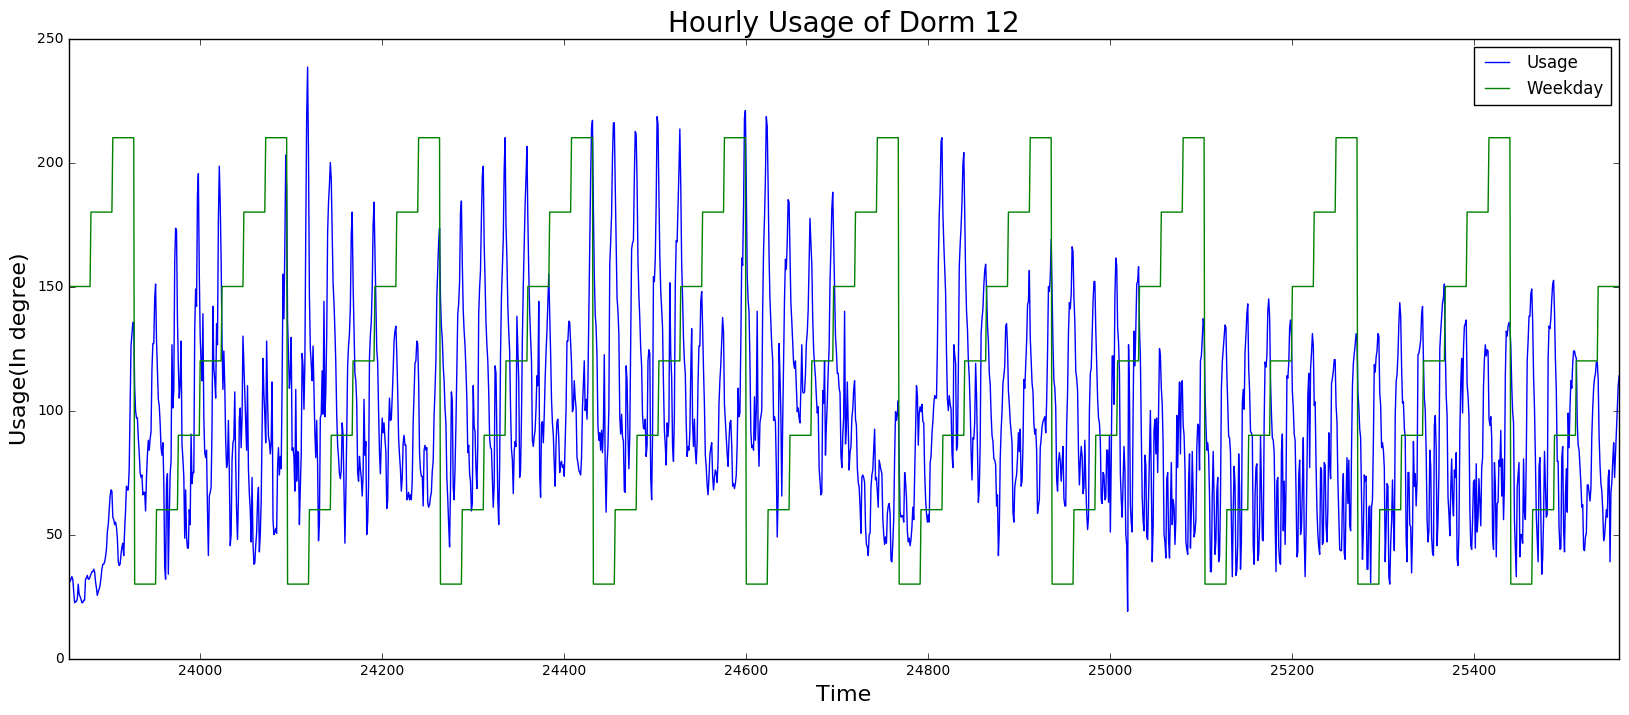

In [368]:
# 71 天每小時的用電資料 (1704個點)
df_dorm_12.Usage.plot(legend = True)
(df_dorm_12.Weekday * 30).plot(legend = True)
# plt.xlabel('index')
plt.title('Hourly Usage of Dorm 12', fontsize = 20)
plt.ylabel('Usage(In degree)',fontsize = 16)
plt.xlabel('Time',fontsize = 16)

               DateTime       Area Building      Loop  Type  Usage       Date  \
23856  2017/09/01 00:00  southArea  dorm_12  mainLoop  dorm   31.0 2017-09-01   
23857  2017/09/01 01:00  southArea  dorm_12  mainLoop  dorm   31.0 2017-09-01   
23858  2017/09/01 02:00  southArea  dorm_12  mainLoop  dorm   32.0 2017-09-01   
23859  2017/09/01 03:00  southArea  dorm_12  mainLoop  dorm   33.0 2017-09-01   
23860  2017/09/01 04:00  southArea  dorm_12  mainLoop  dorm   32.0 2017-09-01   

       Weekday   Time  Cost  
23856      5.0  00:00  93.0  
23857      5.0  01:00  93.0  
23858      5.0  02:00  96.0  
23859      5.0  03:00  99.0  
23860      5.0  04:00  96.0  


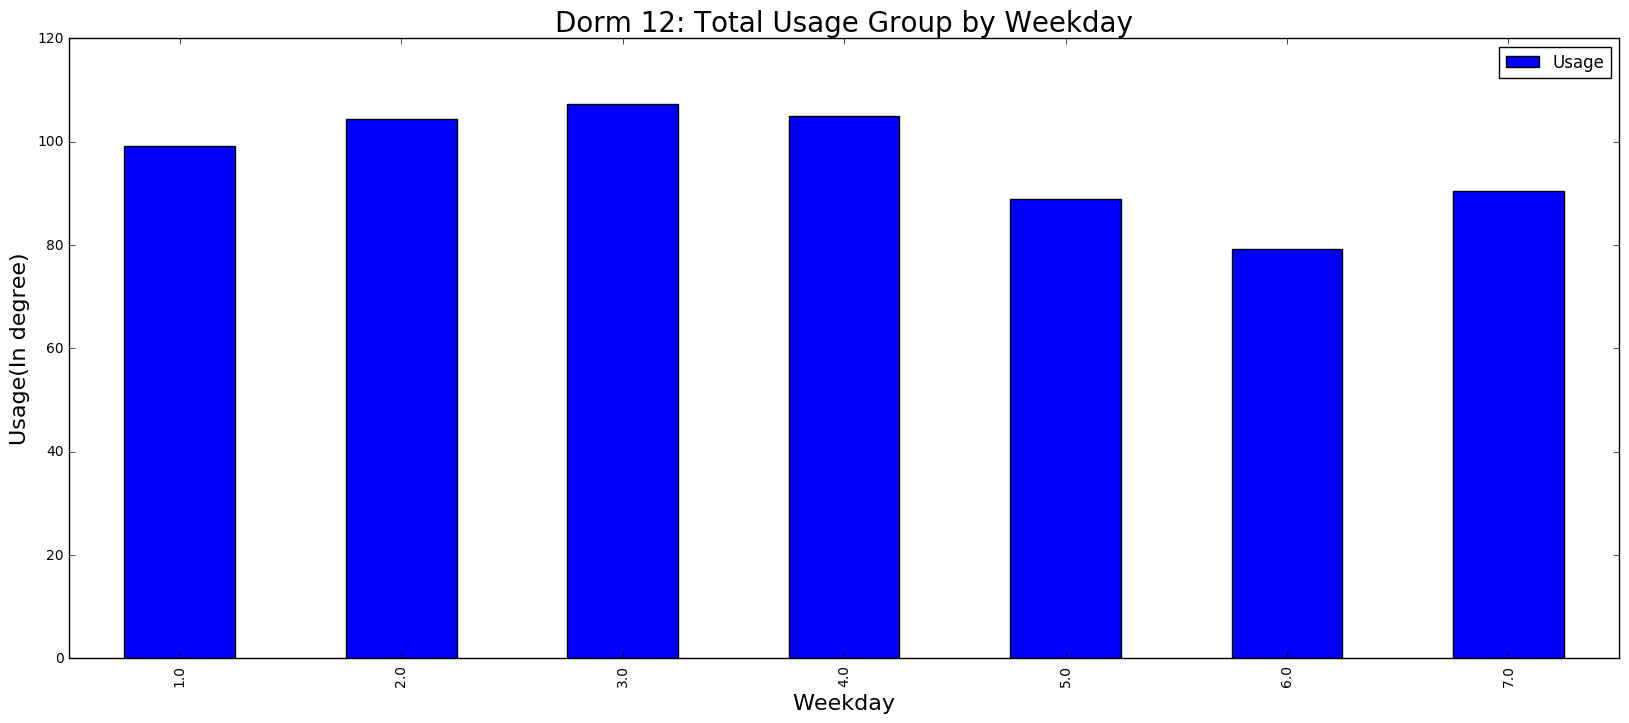

In [369]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').mean()
print(df_dorm_12.head())
df_dorm_12_byWeekday.Usage.plot.bar(legend = True)

plt.title('Dorm 12: Total Usage Group by Weekday', fontsize = 20)
plt.ylabel('Usage(In degree)',fontsize = 16)
plt.xlabel('Weekday',fontsize = 16)

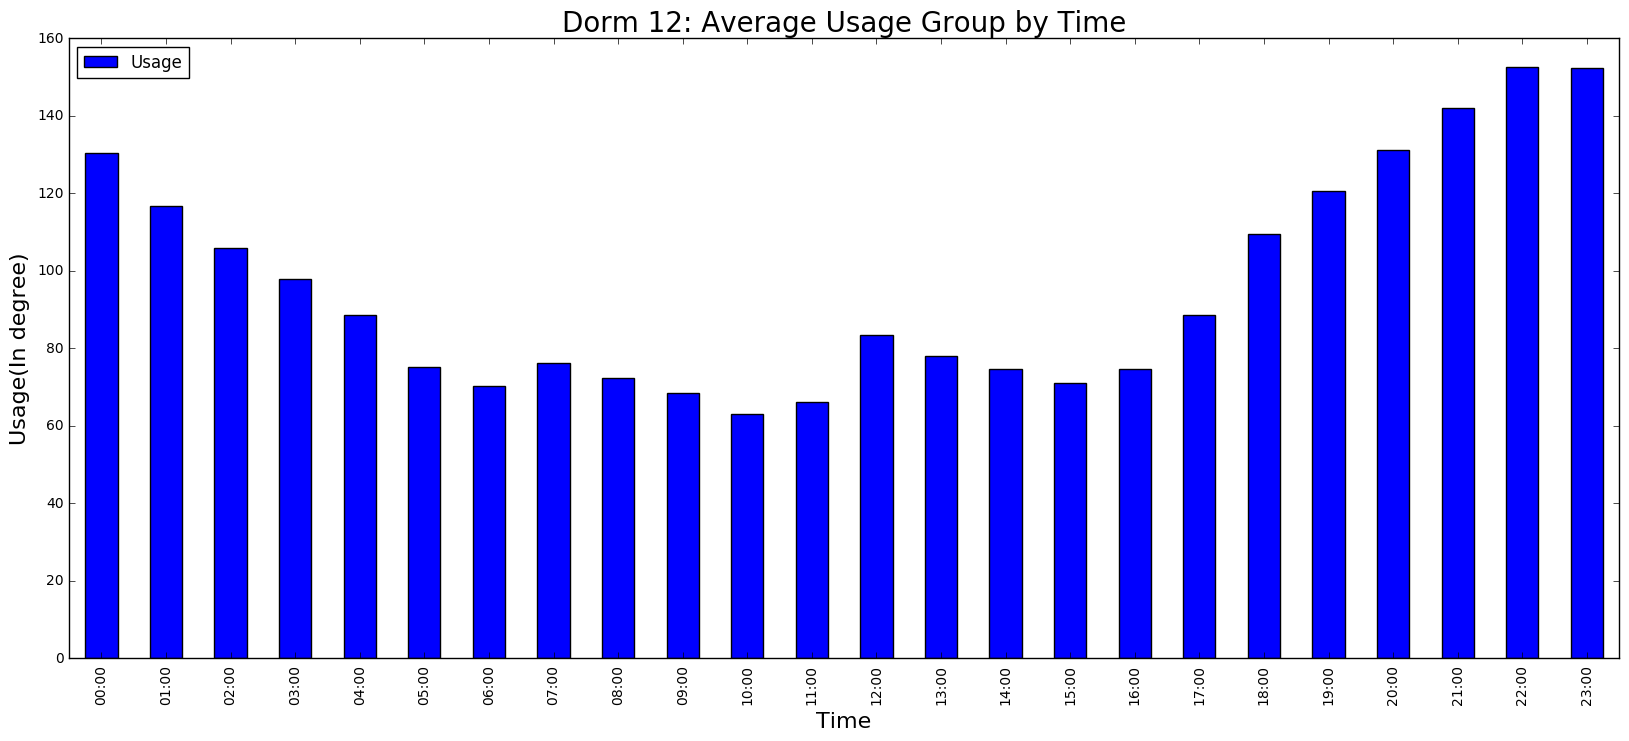

In [412]:
df_dorm_12.groupby('Time').Usage.mean().plot.bar(legend = True)
plt.title('Dorm 12: Average Usage Group by Time', fontsize = 20)
plt.ylabel('Usage(In degree)',fontsize = 16)
plt.xlabel('Time',fontsize = 16)

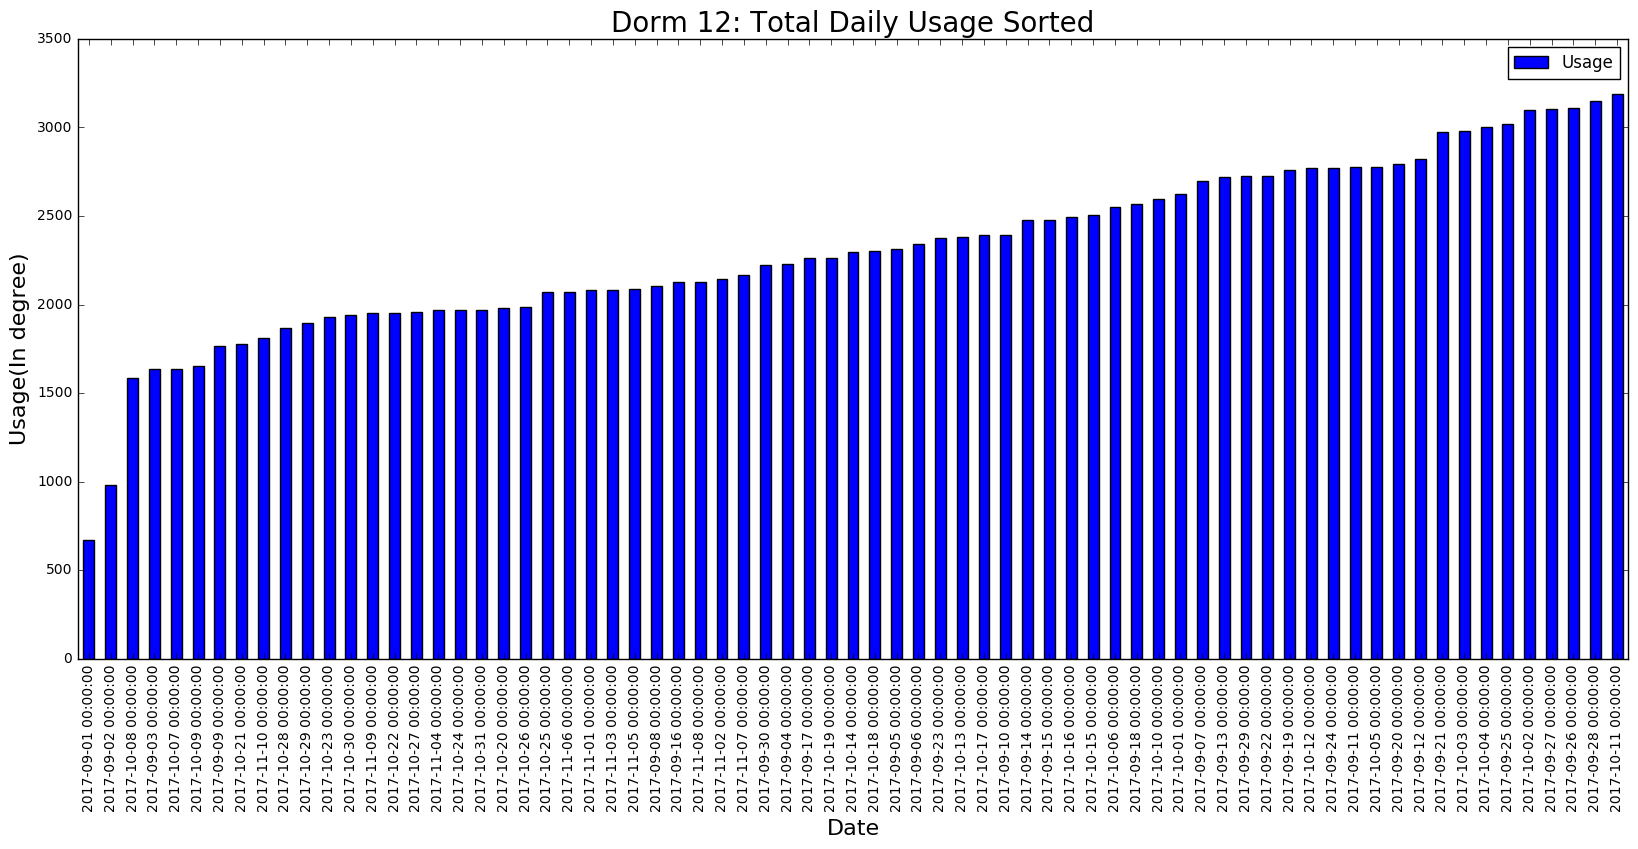

In [393]:
df_dorm_12_dailysum_sorted = df_dorm_12.groupby('Date').sum().sort_values('Usage')
df_dorm_12_dailysum_sorted.Weekday = df_dorm_12_dailysum_sorted.Weekday/24
df_dorm_12_dailysum_sorted.Usage.plot.bar(legend = True)
plt.title('Dorm 12: Total Daily Usage Sorted', fontsize = 20)
plt.ylabel('Usage(In degree)',fontsize = 16)
plt.xlabel('Date',fontsize = 16)

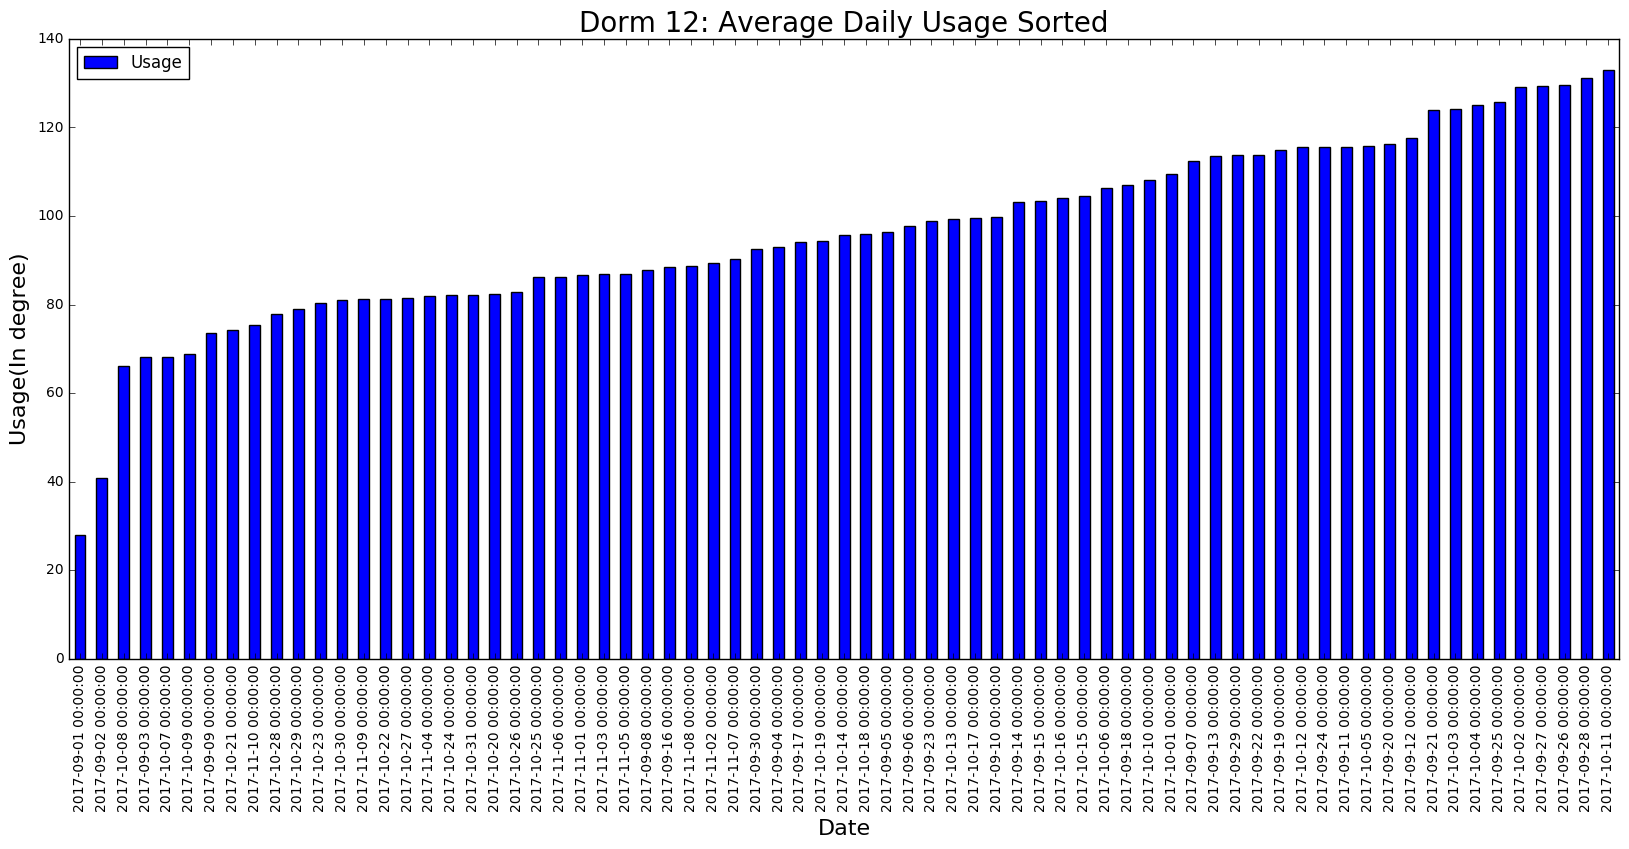

In [394]:
df_dorm_12_dailymean_sorted = df_dorm_12.groupby('Date').mean().sort_values('Usage')
df_dorm_12_dailymean_sorted.Usage.plot.bar(legend = True)
plt.title('Dorm 12: Average Daily Usage Sorted', fontsize = 20)
plt.ylabel('Usage(In degree)',fontsize = 16)
plt.xlabel('Date',fontsize = 16)

In [396]:
# 最高用電的幾天是...
# TBD: 為什麼這幾天會比較高呢？
print('Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailysum_sorted[-10:])
print('Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailymean_sorted[-10:])

Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10
             Usage  Weekday    Cost
Date                               
2017-09-12  2821.5      2.0  8464.5
2017-09-21  2973.5      4.0  8920.5
2017-10-03  2981.0      2.0  8943.0
2017-10-04  3003.0      3.0  9009.0
2017-09-25  3019.0      1.0  9057.0
2017-10-02  3100.0      1.0  9300.0
2017-09-27  3105.0      3.0  9315.0
2017-09-26  3108.0      2.0  9324.0
2017-09-28  3150.0      4.0  9450.0
2017-10-11  3189.5      3.0  9568.5
Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10
                 Usage  Weekday      Cost
Date                                     
2017-09-12  117.562500      2.0  352.6875
2017-09-21  123.895833      4.0  371.6875
2017-10-03  124.208333      2.0  372.6250
2017-10-04  125.125000      3.0  375.3750
2017-09-25  125.791667      1.0  377.3750
2017-10-02  129.166667      1.0  387.5000
2017-09-27  129.375000      3.0  388.1250
2017-09-26  129.500000      2.0  388.5000
2017-09-28  131.250000      4.0  393.750

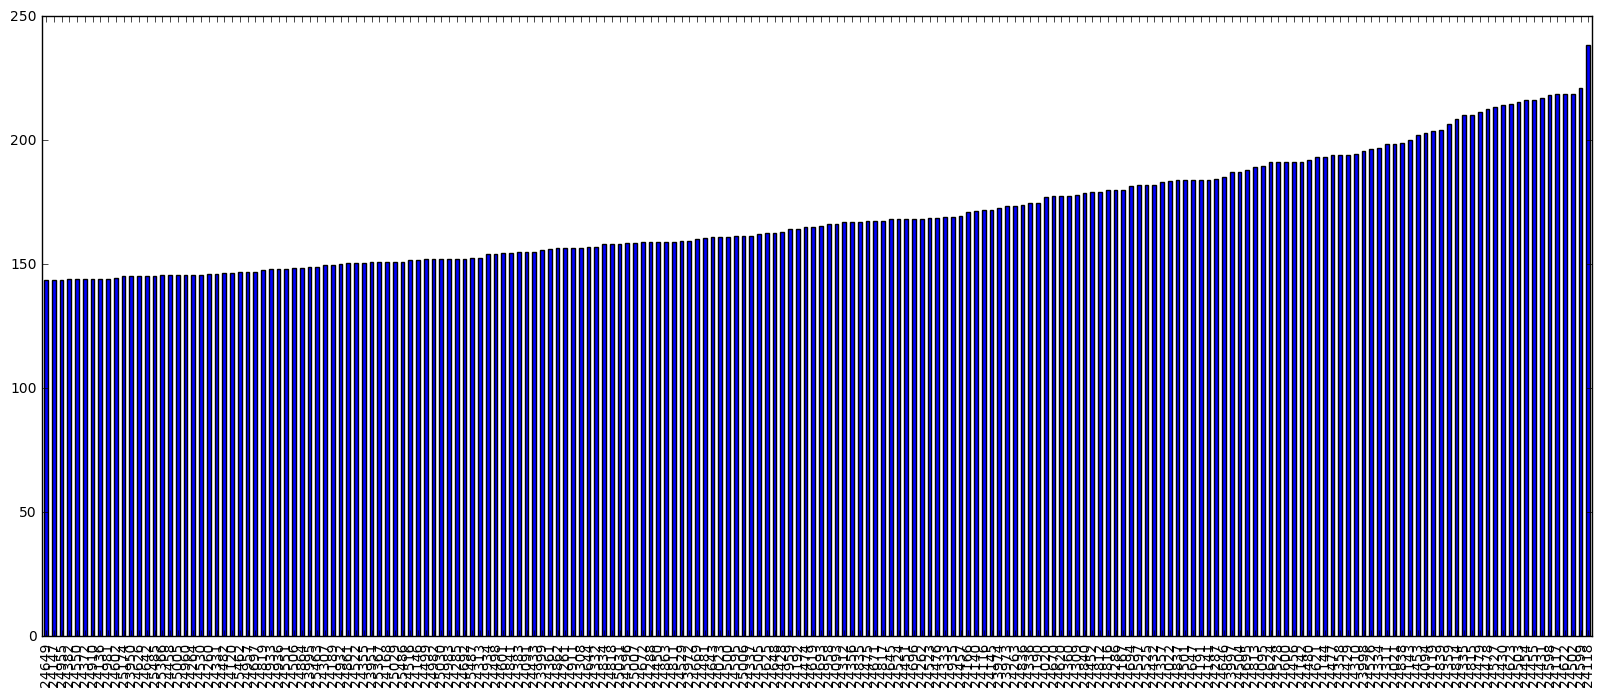

In [431]:
df_dorm_12_sorted_top200 = df_dorm_12.sort_values('Usage')[-200:]
df_dorm_12_sorted_top200.Usage.plot.bar()

In [427]:
# 最耗電的時段
df_dorm_12_sorted_top200.Time.value_counts()

22:00    39
23:00    37
21:00    31
00:00    24
20:00    20
19:00    15
01:00    15
02:00     8
18:00     6
12:00     2
03:00     2
16:00     1
Name: Time, dtype: int64

In [428]:
# 最耗電的日子
df_dorm_12_sorted_top200.Weekday.value_counts()

3.0    45
2.0    45
4.0    40
1.0    33
7.0    21
5.0    14
6.0     2
Name: Weekday, dtype: int64

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Cost
24118,2017/09/11 22:00,southArea,dorm_12,mainLoop,dorm,238.5,2017-09-11,1.0,22:00,715.5


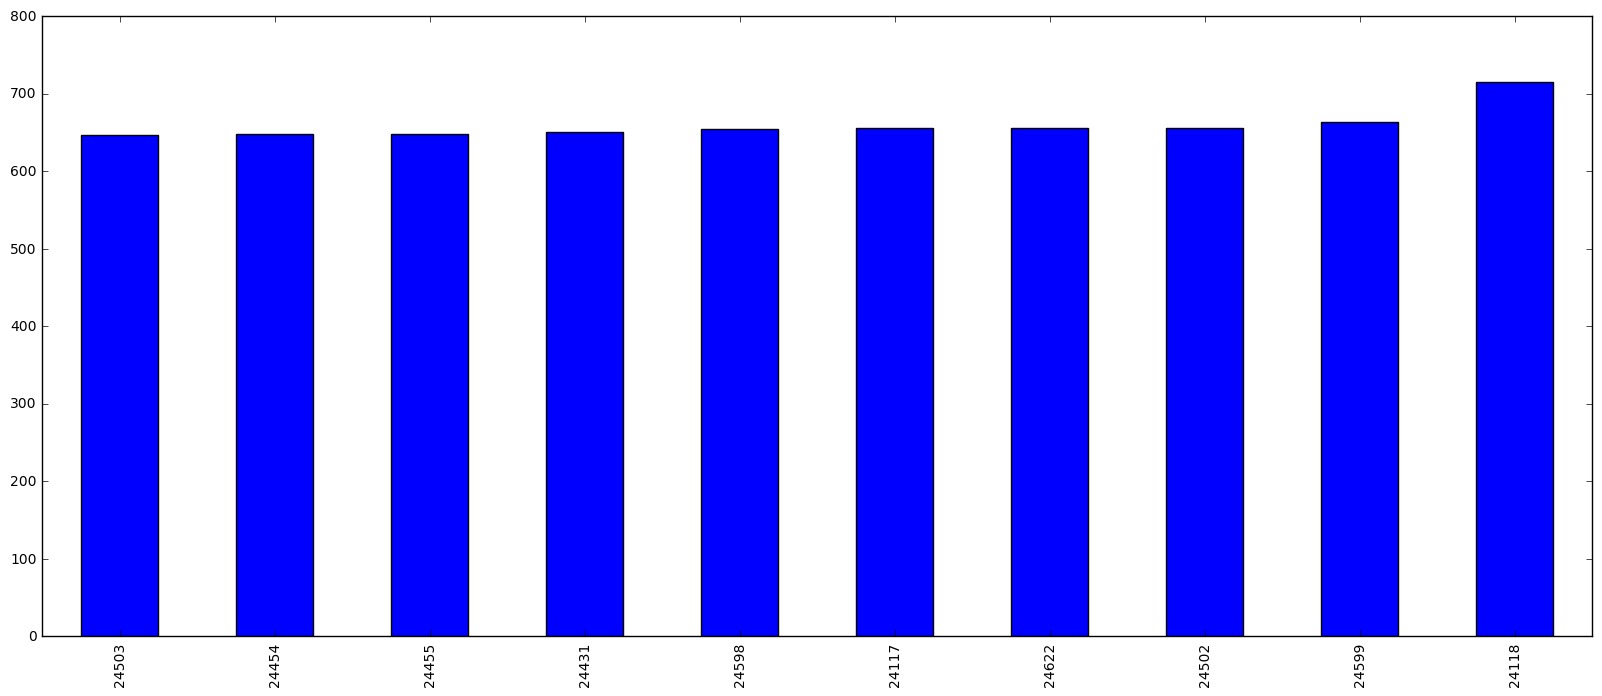

In [429]:
df_dorm_12_sorted_top100[-10:].Cost.plot.bar()
#發現有一天真的特耗電

df_dorm_12_sorted_top100[-1:]
# 2017/09/11 22:00 用電是 238.5, (12舍平均用電是96)

2017/9/11 為什麼用那麼多電呢？
我去查了日曆，原來是開學日啊！

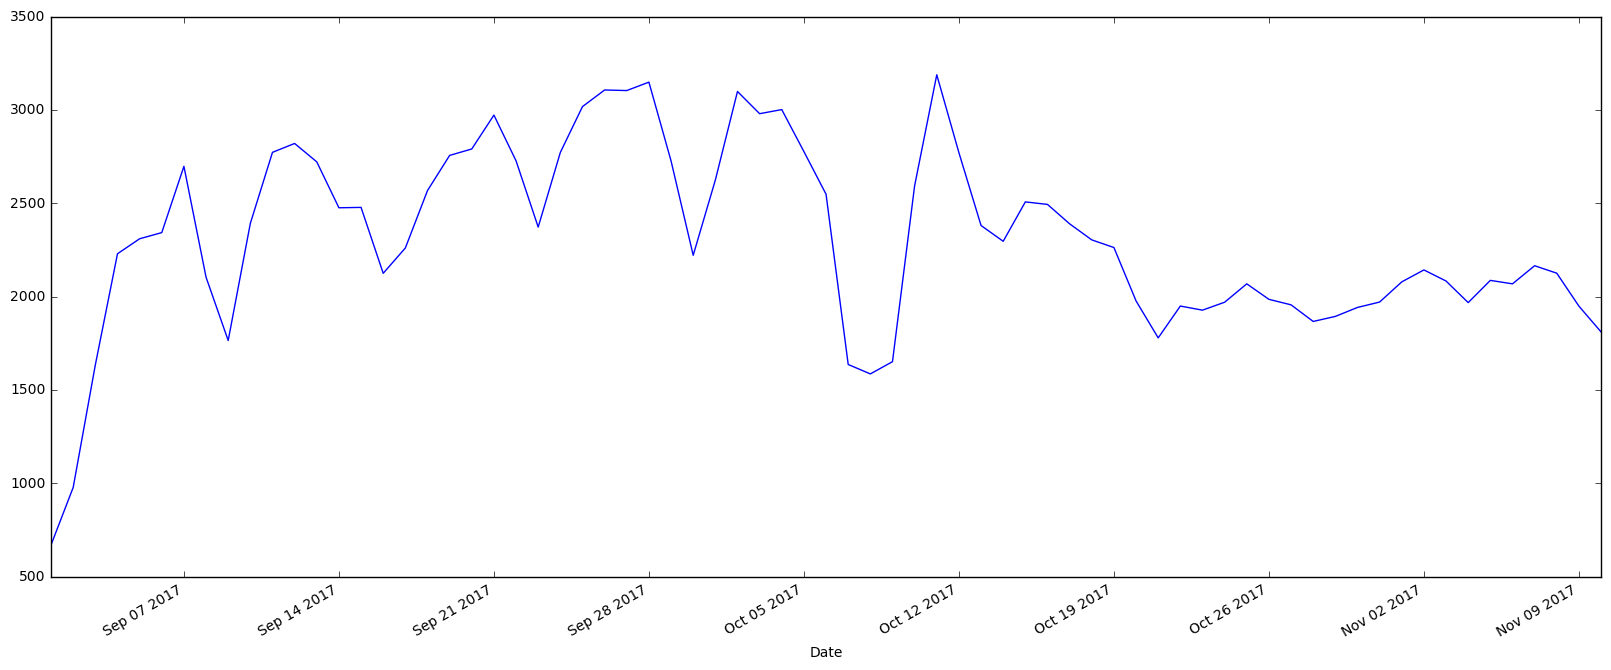

In [316]:
df_dorm_12_dailysum_sorted.Usage.plot.line()

In [317]:
# df_dorm_12[df_dorm_12.Time == '23:00'].info()

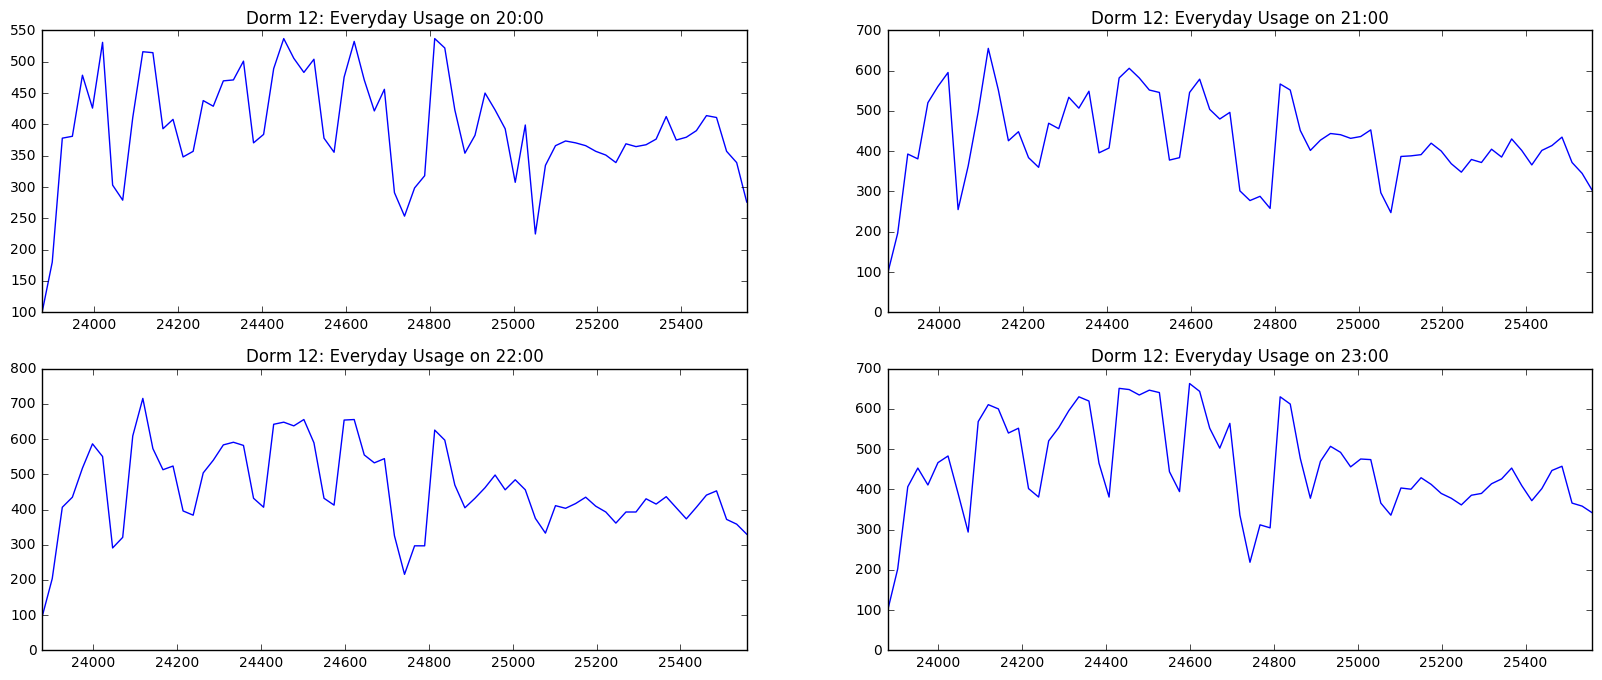

In [451]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)


df_dorm_12[df_dorm_12.Time == '20:00'].Cost.plot(ax=axes[0,0],title = 'Dorm 12: Everyday Usage on 20:00')
df_dorm_12[df_dorm_12.Time == '21:00'].Cost.plot(ax=axes[0,1],title = 'Dorm 12: Everyday Usage on 21:00')
df_dorm_12[df_dorm_12.Time == '22:00'].Cost.plot(ax=axes[1,0],title = 'Dorm 12: Everyday Usage on 22:00')
df_dorm_12[df_dorm_12.Time == '23:00'].Cost.plot(ax=axes[1,1],title = 'Dorm 12: Everyday Usage on 23:00')


Time
00:00    Axes(0.125,0.125;0.775x0.775)
01:00    Axes(0.125,0.125;0.775x0.775)
02:00    Axes(0.125,0.125;0.775x0.775)
03:00    Axes(0.125,0.125;0.775x0.775)
04:00    Axes(0.125,0.125;0.775x0.775)
05:00    Axes(0.125,0.125;0.775x0.775)
06:00    Axes(0.125,0.125;0.775x0.775)
07:00    Axes(0.125,0.125;0.775x0.775)
08:00    Axes(0.125,0.125;0.775x0.775)
09:00    Axes(0.125,0.125;0.775x0.775)
10:00    Axes(0.125,0.125;0.775x0.775)
11:00    Axes(0.125,0.125;0.775x0.775)
12:00    Axes(0.125,0.125;0.775x0.775)
13:00    Axes(0.125,0.125;0.775x0.775)
14:00    Axes(0.125,0.125;0.775x0.775)
15:00    Axes(0.125,0.125;0.775x0.775)
16:00    Axes(0.125,0.125;0.775x0.775)
17:00    Axes(0.125,0.125;0.775x0.775)
18:00    Axes(0.125,0.125;0.775x0.775)
19:00    Axes(0.125,0.125;0.775x0.775)
20:00    Axes(0.125,0.125;0.775x0.775)
21:00    Axes(0.125,0.125;0.775x0.775)
22:00    Axes(0.125,0.125;0.775x0.775)
23:00    Axes(0.125,0.125;0.775x0.775)
Name: Usage, dtype: object

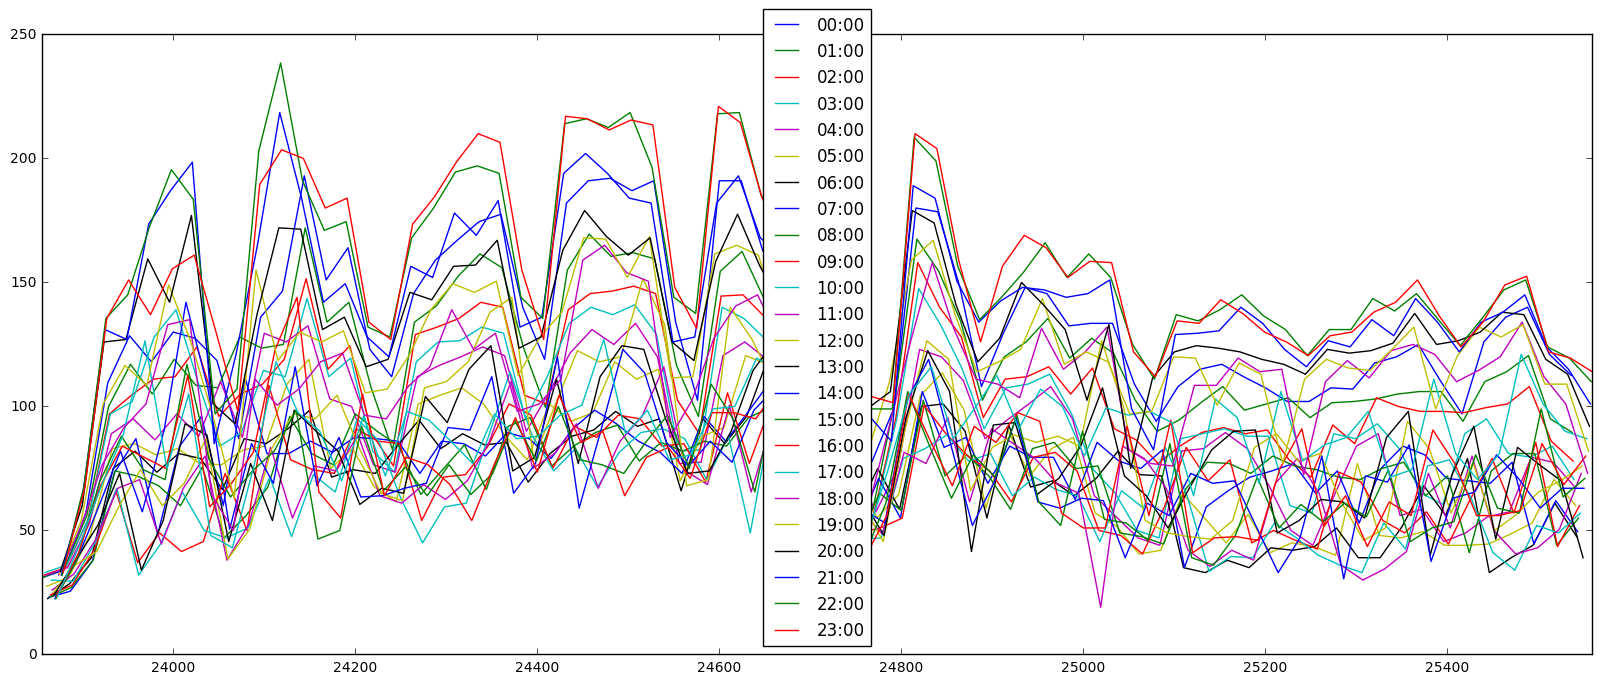

In [475]:
# 未完

df_dorm_12.Time.unique()
morning = ['01:00', '02:00', '03:00', '04:00', '05:00', '06:00','07:00', '08:00']
afternoon = ['09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00']
night = [ '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00','00:00']
# df_dorm_12.Time.item in ['18:00','19:00']
# df_dorm_12_byTime_m = df_dorm_12[df_dorm_12.Time.valus in morning].groupby('Time')
# df_dorm_12_byTime_a = df_dorm_12[df_dorm_12.Time in afternoon].groupby('Time')
# df_dorm_12_byTime_n = df_dorm_12[df_dorm_12.Time in night].groupby('Time')

df_dorm_12_byTime = df_dorm_12.groupby('Time')
df_dorm_12_byTime.Usage.plot(legend = True)


# bins = [0, 5, 15, 30]
# names = ['Cheap', 'Normal', 'Expensive']
# df_dorm_12_byTime_m = pd.cut(df_dorm_12.Time,bins, labels=morning)